In [1]:
import gensim
import os
import collections
import smart_open
import random
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from pprint import pprint
import numpy as np
from sklearn import svm
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint

d:\Anaconda3\envs\MLOntology\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
d:\Anaconda3\envs\MLOntology\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#global variabls

directory_path =  "D:/MLOntology/NCIt/"
data_path = directory_path + "data/hier/"
vector_model_path = directory_path +"vectorModel/"
cnn_model_path = directory_path +"cnnModel/hier/"


In [3]:
import re
def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

In [4]:
#read class label file
#create mapping from id to labels  
#iso-8859-1 , encoding="iso-8859-1"
conceptLabelDict={}
errors=[]

def read_label(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                conceptID = get_trailing_number(splitted[1])
                conceptLabelDict[conceptID] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

label_file = data_path + "ontClassLabels_owl_ncit.txt"
read_label(label_file)
print(conceptLabelDict["4863"])
print(conceptLabelDict["115117"])
print(errors)

prostate carcinoma
stage ia esophageal cancer ajcc v7
[]


In [5]:
conceptPairDict={}
errors=[]
conceptPairList=[]

def read_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                childID = get_trailing_number(splitted[1])
                parentID = get_trailing_number(splitted[2].replace("\r\n", ""))
                conceptPairList.append([childID, parentID , 1])
#                 conceptPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

pair_file = data_path + "ontHierarchy_owl_ncit.txt"
read_pair(pair_file)

checkpairs = conceptPairList[10:15]
print(checkpairs)
print(len(conceptPairList))

[['4861', '7318', 1], ['87152', '87150', 1], ['87153', '140032', 1], ['87154', '87153', 1], ['87155', '87153', 1]]
16533


In [6]:
conceptNotPairDict={}
conceptNotPairList=[]

def read_not_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==2:
                childID = get_trailing_number(splitted[0])
                notparentID = get_trailing_number(splitted[1].replace("\r\n", ""))
                conceptNotPairList.append([childID, notparentID, 0])
#                 conceptNotPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

notPair_file = data_path + "taxNotPairs_owl_ncit.txt"
read_not_pair(notPair_file)


first2pairs =conceptNotPairList[10:15]
print(first2pairs)
print(len(conceptNotPairList))

[['7918', '9151', 0], ['7918', '48612', 0], ['7918', '48613', 0], ['7918', '91231', 0], ['7918', '66753', 0]]
37147


In [7]:
if len(conceptPairList) < len(conceptNotPairList):
    # In-place shuffle
    random.shuffle(conceptNotPairList)
    leftPairList = conceptNotPairList[len(conceptPairList):]
    conceptNotPairList = conceptNotPairList[:len(conceptPairList)]
else:
    # Updown sampling negative samples
    random.shuffle(conceptNotPairList)
    duplicatedList = conceptNotPairList[:len(conceptPairList) - len(conceptNotPairList)]
    random.shuffle(conceptNotPairList)
    conceptNotPairList = conceptNotPairList.extend(duplicatedList)

assert len(conceptPairList) == len(conceptNotPairList), "Mistmatch in Positive & Negative samples!"

In [8]:
#  PV-DBOW
# vector_model_file = vector_model_path + "model0"

# vector_model = gensim.models.Doc2Vec.load(vector_model_file)

# inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
# pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

In [9]:
# PV-DM seems better??
vector_model_file = vector_model_path + "model1"

vector_model = gensim.models.Doc2Vec.load(vector_model_file)

inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

[('3801', 0.573110818862915),
 ('7387', 0.5459988117218018),
 ('7158', 0.5257105827331543),
 ('66803', 0.5169489979743958),
 ('7087', 0.5158716440200806),
 ('6409', 0.5148918628692627),
 ('136619', 0.5060052871704102),
 ('3191', 0.5028414726257324),
 ('8502', 0.4973357617855072),
 ('3087', 0.473834365606308)]


In [10]:
vector_model.docvecs['7918']

array([ 1.12278104e-01,  6.86569437e-02, -1.24297813e-01,  2.23319721e-03,
        3.53817977e-02, -1.57626167e-01,  9.55056846e-02, -6.64356165e-03,
        5.35981506e-02, -1.73459724e-02,  6.37169927e-02,  2.59661172e-02,
       -3.96479517e-02,  5.85773867e-03,  1.54108971e-01, -2.09995508e-02,
        3.63172963e-02,  6.07878082e-02,  1.01029929e-02,  8.57971609e-02,
        9.79144797e-02, -1.28200814e-01, -7.13667497e-02, -3.62776853e-02,
       -8.94697011e-02, -1.46133035e-01,  6.03192374e-02, -2.75994018e-02,
       -1.33479005e-02, -1.47091411e-02, -5.71595430e-02, -3.07746418e-02,
       -3.63636203e-02, -1.42001789e-02,  8.44926573e-03,  1.99984163e-01,
        2.32352003e-01,  1.72088407e-02,  3.46314073e-01, -1.67805614e-04,
        2.23070253e-02, -2.78270878e-02, -2.81399842e-02, -4.84447554e-02,
        6.20759241e-02,  9.16333520e-04,  3.92444283e-02,  4.46287617e-02,
       -9.79690775e-02,  3.11729629e-02, -2.01291181e-02,  6.88659623e-02,
        5.21936752e-02,  

In [11]:
def readFromPairList(id_pair_list, id_notPair_list):
    pair_list = id_pair_list + id_notPair_list
    random.shuffle(pair_list)
    idpairs_list =[]
    label_list =[]
    for i, line in enumerate(pair_list):      
        idpairs_list.append([line[0], line[1]])
        label_list.append(line[2])
    return idpairs_list, label_list

idpairs_list, label_list= readFromPairList(conceptPairList, conceptNotPairList)

print(label_list[:20])

[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1]


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(idpairs_list, label_list, test_size = 0.2, shuffle= True)
print(X_train[:20])
print(X_validation[:20])
print(y_train[:20])
print(y_validation[:20])

[['136491', '91232'], ['4671', '27939'], ['8068', '27356'], ['8626', '45514'], ['7469', '133794'], ['40006', '7284'], ['9365', '65195'], ['134748', '134747'], ['5496', '3864'], ['35674', '7082'], ['5853', '3042'], ['40144', '40153'], ['139745', '139744'], ['40181', '2940'], ['9106', '3677'], ['88122', '140511'], ['7291', '49017'], ['134678', '134672'], ['40365', '27825'], ['9377', '3288']]
[['4735', '27826'], ['7704', '27268'], ['8809', '36034'], ['7471', '5600'], ['103817', '9479'], ['3359', '9415'], ['3436', '3674'], ['38161', '3211'], ['5722', '9120'], ['4215', '4862'], ['3387', '7337'], ['96699', '4170'], ['8575', '6158'], ['40260', '2917'], ['5323', '3156'], ['6286', '9475'], ['80342', '80340'], ['124272', '114833'], ['7927', '96963'], ['8533', '90524']]
[1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1]


In [13]:
def getVectorFromModel(concept_id, conceptLabelDict, model):
    if concept_id in model.docvecs:
        concept_vector= model.docvecs[concept_id]
    else:
        print("%s not found, get inferred vector "%(concept_id))
        concept_label = conceptLabelDict[concept_id]
        concept_vector= model.infer_vector(concept_label.split())
    return concept_vector

def getVector(line, conceptLabelDict, model):        
    a = getVectorFromModel(line[0], conceptLabelDict, model)
    b = getVectorFromModel(line[1], conceptLabelDict, model)
    c = np.array((a, b))
    c = c.T 
#     c = np.expand_dims(c, axis=2)
#     print(c.shape)
    return c

In [14]:
def stackVector(vector):
    from numpy import dstack
    return dstack((vector, vector, vector))

In [15]:
n_channels=2 

def get_batches(x_samples, y_samples, batch_size=64):
    samples = list(zip(x_samples, y_samples))
    num_samples = len(samples)
    
    shuffle(samples)
    for offset in range(0, num_samples, batch_size):
        batch_samples = samples[offset:offset+batch_size]

        X_samples = []
        Y_samples= []
        for batch_sample in batch_samples:
            pair_list = batch_sample[0]
            data_vector = getVector(pair_list, conceptLabelDict, vector_model)
#                 data_vector = stackVector(data_vector)
#                 print(data_vector.shape)
            X_samples.append(data_vector)
            class_label = batch_sample[1] 
            Y_samples.append(class_label)

        X_samples = np.array(X_samples).astype('float32')
        Y_samples = np.eye(n_channels)[Y_samples]
#             print('one batch ready')
        yield shuffle(X_samples, Y_samples)

def get_batches(X, y, batch_size = 100):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [16]:
# Imports
import tensorflow as tf

# build the model??
batch_size = 2000       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000
lambda_loss_amount = 0.001

n_classes = 2
n_channels = 2


graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

    
with graph.as_default():
    # (batch, 128, 2) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')


with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()) 
    # L2 loss prevents this overkill neural network to overfit the data
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))+l2
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    # predicted class label
    predict = tf.argmax(logits,1, name ="predict")   #the predicted class
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [17]:
if (os.path.exists( cnn_model_path + 'checkpoints-cnn') == False):
    os.makedirs( cnn_model_path + 'checkpoints-cnn')

In [18]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 50 iters
            if (iteration % 50 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 100 iterations
            if (iteration%100 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_validation, y_validation, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess, cnn_model_path + "checkpoints-cnn/har.ckpt")

Epoch: 3/1000 Iteration: 50 Train loss: 0.771780 Train acc: 0.565500
Epoch: 7/1000 Iteration: 100 Train loss: 0.760627 Train acc: 0.600000
Epoch: 7/1000 Iteration: 100 Validation loss: 0.761726 Validation acc: 0.585347
Epoch: 10/1000 Iteration: 150 Train loss: 0.747314 Train acc: 0.597000
Epoch: 14/1000 Iteration: 200 Train loss: 0.731736 Train acc: 0.607000
Epoch: 14/1000 Iteration: 200 Validation loss: 0.732271 Validation acc: 0.615494
Epoch: 17/1000 Iteration: 250 Train loss: 0.718124 Train acc: 0.614000
Epoch: 21/1000 Iteration: 300 Train loss: 0.702382 Train acc: 0.636000
Epoch: 21/1000 Iteration: 300 Validation loss: 0.698577 Validation acc: 0.636605
Epoch: 24/1000 Iteration: 350 Train loss: 0.679049 Train acc: 0.652655
Epoch: 28/1000 Iteration: 400 Train loss: 0.679637 Train acc: 0.651000
Epoch: 28/1000 Iteration: 400 Validation loss: 0.678627 Validation acc: 0.655684
Epoch: 32/1000 Iteration: 450 Train loss: 0.670932 Train acc: 0.659500
Epoch: 35/1000 Iteration: 500 Train loss:

Epoch: 264/1000 Iteration: 3700 Train loss: 0.559686 Train acc: 0.752000
Epoch: 264/1000 Iteration: 3700 Validation loss: 0.569829 Validation acc: 0.750100
Epoch: 267/1000 Iteration: 3750 Train loss: 0.567069 Train acc: 0.736000
Epoch: 271/1000 Iteration: 3800 Train loss: 0.572279 Train acc: 0.747000
Epoch: 271/1000 Iteration: 3800 Validation loss: 0.569562 Validation acc: 0.749539
Epoch: 274/1000 Iteration: 3850 Train loss: 0.545147 Train acc: 0.754425
Epoch: 278/1000 Iteration: 3900 Train loss: 0.562715 Train acc: 0.744000
Epoch: 278/1000 Iteration: 3900 Validation loss: 0.568536 Validation acc: 0.747503
Epoch: 282/1000 Iteration: 3950 Train loss: 0.553570 Train acc: 0.757500
Epoch: 285/1000 Iteration: 4000 Train loss: 0.562175 Train acc: 0.740000
Epoch: 285/1000 Iteration: 4000 Validation loss: 0.567119 Validation acc: 0.751728
Epoch: 289/1000 Iteration: 4050 Train loss: 0.555052 Train acc: 0.752000
Epoch: 292/1000 Iteration: 4100 Train loss: 0.567160 Train acc: 0.749000
Epoch: 292/

Epoch: 521/1000 Iteration: 7300 Train loss: 0.540347 Train acc: 0.763000
Epoch: 521/1000 Iteration: 7300 Validation loss: 0.547440 Validation acc: 0.772965
Epoch: 524/1000 Iteration: 7350 Train loss: 0.504552 Train acc: 0.811947
Epoch: 528/1000 Iteration: 7400 Train loss: 0.535873 Train acc: 0.772500
Epoch: 528/1000 Iteration: 7400 Validation loss: 0.546605 Validation acc: 0.765264
Epoch: 532/1000 Iteration: 7450 Train loss: 0.527874 Train acc: 0.772000
Epoch: 535/1000 Iteration: 7500 Train loss: 0.534780 Train acc: 0.779500
Epoch: 535/1000 Iteration: 7500 Validation loss: 0.546959 Validation acc: 0.773118
Epoch: 539/1000 Iteration: 7550 Train loss: 0.528636 Train acc: 0.773500
Epoch: 542/1000 Iteration: 7600 Train loss: 0.534861 Train acc: 0.767500
Epoch: 542/1000 Iteration: 7600 Validation loss: 0.546497 Validation acc: 0.766200
Epoch: 546/1000 Iteration: 7650 Train loss: 0.541003 Train acc: 0.770500
Epoch: 549/1000 Iteration: 7700 Train loss: 0.500957 Train acc: 0.803097
Epoch: 549/

Epoch: 774/1000 Iteration: 10850 Train loss: 0.469765 Train acc: 0.834071
Epoch: 778/1000 Iteration: 10900 Train loss: 0.517356 Train acc: 0.794000
Epoch: 778/1000 Iteration: 10900 Validation loss: 0.533866 Validation acc: 0.774389
Epoch: 782/1000 Iteration: 10950 Train loss: 0.513397 Train acc: 0.787500
Epoch: 785/1000 Iteration: 11000 Train loss: 0.521567 Train acc: 0.786500
Epoch: 785/1000 Iteration: 11000 Validation loss: 0.533768 Validation acc: 0.781654
Epoch: 789/1000 Iteration: 11050 Train loss: 0.516562 Train acc: 0.783500
Epoch: 792/1000 Iteration: 11100 Train loss: 0.517051 Train acc: 0.774500
Epoch: 792/1000 Iteration: 11100 Validation loss: 0.533576 Validation acc: 0.772982
Epoch: 796/1000 Iteration: 11150 Train loss: 0.522943 Train acc: 0.782000
Epoch: 799/1000 Iteration: 11200 Train loss: 0.475862 Train acc: 0.807522
Epoch: 799/1000 Iteration: 11200 Validation loss: 0.533218 Validation acc: 0.781904
Epoch: 803/1000 Iteration: 11250 Train loss: 0.515520 Train acc: 0.78950

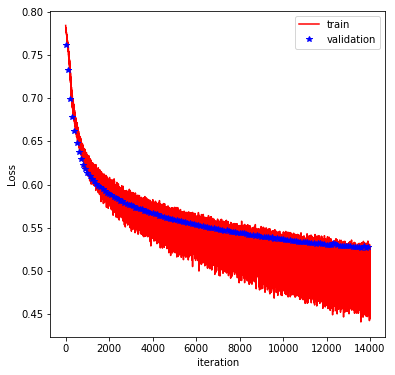

In [32]:
import matplotlib.pyplot as plt
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 100 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

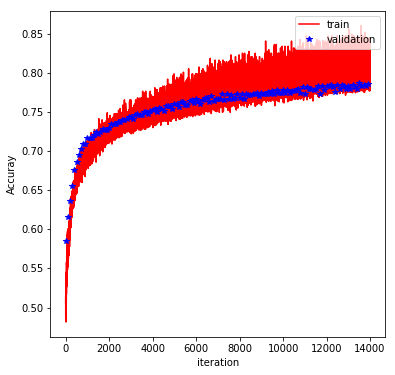

In [20]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 100 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [21]:
testStrings = '''4092,3677,1
4556,4555,1
4408,4242,1
62210,4133,1
4459,84509,1
6750,2896,1
3942,7158,1
3754,65157,1
3084,65157,1
6985,65157,1
3061,65157,1
27939,65157,1
4139,2915,1
3058,2937,1
4047,2937,1
7335,3010,1
3375,9343,1
4150,45921,1'''

X_test = []
y_test = []
X_test_reverse = []

for line in testStrings.splitlines():
    word = line.replace("\r\n", "").split(",")
    X_test.append([word[0], word[1]])
    X_test_reverse.append([word[1], word[0]])
    y_test.append(int(word[2]))
#     print(word)
#     print(vector_model.docvecs[word[0]])
#     print(vector_model.docvecs[word[1]])

print(len(X_test))

18


In [22]:
print(X_test)
print(y_test)

[['4092', '3677'], ['4556', '4555'], ['4408', '4242'], ['62210', '4133'], ['4459', '84509'], ['6750', '2896'], ['3942', '7158'], ['3754', '65157'], ['3084', '65157'], ['6985', '65157'], ['3061', '65157'], ['27939', '65157'], ['4139', '2915'], ['3058', '2937'], ['4047', '2937'], ['7335', '3010'], ['3375', '9343'], ['4150', '45921']]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [23]:
for pair in X_test:
    if pair in X_train or pair in X_validation:
        print(pair, ' yes')
        X_test.remove(pair)

print(len(X_test))

['7335', '3010']  yes
17


In [24]:
test_acc = []
batch_size = len(X_test)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint(cnn_model_path + 'checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from D:/MLOntology/NCIt/cnnModel/hier/checkpoints-cnn/har.ckpt
Test accuracy: 0.294118


In [34]:
n_channels=2 

def get_batches_withName(x_samples, y_samples, batch_size=64):
    samples = list(zip(x_samples, y_samples))
    num_samples = len(samples)
    
    shuffle(samples)
    for offset in range(0, num_samples, batch_size):
        batch_samples = samples[offset:offset+batch_size]

        X_samples = []
        Y_samples= []
        for batch_sample in batch_samples:
            print("{} : {} ".format(batch_sample[0], batch_sample[1]))
            pair_list = batch_sample[0]
            data_vector = getVector(pair_list, conceptLabelDict, vector_model)
#                 data_vector = stackVector(data_vector)
#                 print(data_vector.shape)
            X_samples.append(data_vector)
            class_label = batch_sample[1] 
            Y_samples.append(class_label)

        X_samples = np.array(X_samples).astype('float32')
        Y_samples = np.eye(n_channels)[Y_samples]
#             print('one batch ready')
        yield shuffle(X_samples, Y_samples)


test_pred = []
batch_size = len(X_test)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint(cnn_model_path + 'checkpoints-cnn'))
    
    for x_t, y_t in get_batches_withName(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_pred = sess.run(correct_pred, feed_dict=feed)
        
        print("Test accuracy: {}".format(batch_pred))

INFO:tensorflow:Restoring parameters from D:/MLOntology/NCIt/cnnModel/hier/checkpoints-cnn/har.ckpt


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [2,2,18] rhs shape= [2,4,18]
	 [[Node: save/Assign_6 = Assign[T=DT_FLOAT, _class=["loc:@conv1d/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv1d/kernel/Adam, save/RestoreV2:6)]]

Caused by op 'save/Assign_6', defined at:
  File "d:\Anaconda3\envs\MLOntology\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\Anaconda3\envs\MLOntology\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "d:\Anaconda3\envs\MLOntology\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "d:\Anaconda3\envs\MLOntology\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "d:\Anaconda3\envs\MLOntology\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tornado\ioloop.py", line 759, in _run_callback
    ret = callback()
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\zmq\eventloop\zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-225fd2a27c5e>", line 8, in <module>
    saver = tf.train.Saver()
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\training\saver.py", line 1338, in __init__
    self.build()
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\training\saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\training\saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\training\saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\training\saver.py", line 494, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\training\saver.py", line 185, in restore
    self.op.get_shape().is_fully_defined())
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\ops\state_ops.py", line 283, in assign
    validate_shape=validate_shape)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 59, in assign
    use_locking=use_locking, name=name)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "d:\Anaconda3\envs\MLOntology\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [2,2,18] rhs shape= [2,4,18]
	 [[Node: save/Assign_6 = Assign[T=DT_FLOAT, _class=["loc:@conv1d/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv1d/kernel/Adam, save/RestoreV2:6)]]


In [26]:
testingPairList=[]

def read_test_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==2:
                childID = get_trailing_number(splitted[0])
                notparentID = get_trailing_number(splitted[1].replace("\r\n", ""))
                assert childID in vector_model.docvecs, "%s not in vector model"%(childID)
                assert notparentID in vector_model.docvecs, "%s not in vector model"%(notparentID)
                testingPairList.append([childID, notparentID, 0])
#                 conceptNotPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

testingPair_file = data_path + "testing_owl_ncit.txt"
read_test_pair(testingPair_file)


first2pairs =testingPairList[10:15]
print(first2pairs)
print(len(testingPairList))

[['8784', '86026', 0], ['8784', '7917', 0], ['8784', '86034', 0], ['8784', '86033', 0], ['8784', '86053', 0]]
732906


In [27]:
# remove samples from training samples 

train_pair_list = []
for pair in conceptPairList:
    pair = tuple(pair)
    train_pair_list.append(pair)

train_pair_set = set(train_pair_list)

train_notpair_list = []
for pair in conceptNotPairList:
    pair = tuple(pair)
    train_notpair_list.append(pair)

train_notpair_set = set(train_notpair_list)

testing_pair_list = []
for pair in testingPairList:
    pair = tuple(pair)
    testing_pair_list.append(pair)

testing_pair_set = set(testing_pair_list)



rest_pair_Set = testing_pair_set - train_pair_set - train_notpair_set

In [28]:
type(rest_pair_Set)

rest_pair_list=list(rest_pair_Set)

rest_testingPairList =[]
for t in rest_pair_list:
    rest_testingPairList.append(list(t))


print(rest_testingPairList[:5])
print(len(rest_testingPairList))

[['148300', '3263', 0], ['133670', '5691', 0], ['40300', '129654', 0], ['41245', '9076', 0], ['96959', '6279', 0]]
728400


In [29]:
idpairs_list, label_list= readFromPairList([], rest_testingPairList)

In [30]:
test_rest_acc = []
batch_size = 5000
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint(cnn_model_path + 'checkpoints-cnn'))
    test_iteration = 1
    
    for x_t, y_t in get_batches(idpairs_list, label_list, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_rest_acc.append(batch_acc)
        
        test_iteration += 1
    print("Test accuracy: {:.6f}".format(np.mean(test_rest_acc)))

INFO:tensorflow:Restoring parameters from D:/MLOntology/NCIt/cnnModel/hier/checkpoints-cnn/har.ckpt
Test accuracy: 0.710802


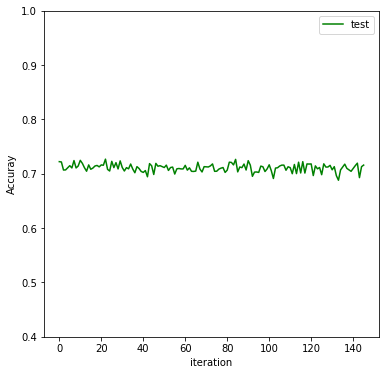

In [31]:
import matplotlib.pyplot as plt
# Plot training and test loss
t = np.arange(test_iteration-1)
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(test_rest_acc), 'g-')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.ylim(0.4, 1)
plt.legend(['test'], loc='upper right')
plt.show()